<a href="https://colab.research.google.com/github/snikhil17/NLP_course_Simplilearn/blob/main/Assignments/ML%20Revision_1/ML_Revision_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Problem Statement**

- Cancer Detection Modelling (Label: diagnosis, Features: remaining columns except id column)

- Deploy two best model based on the following criteria

  - Model1: Get the best model based on Confusion Matrix and Numerical Metrics
  - Model2: Get the best model based on Viz Metrics


- Visualize the decision regions of the generated model based on two features that has highest significance in the dataset with respect to the label.

## **Hint:**
- To find the two best features, you can use support method using SBM that you
	have learned in Feature Engineering class :)

# **Approach:**

---
1. Aquiring Data
2. Load required Libraries and Data
3. Checking for missing, duplicates values and constant variables (variable with only 1 value)
4. Dropping ``id`` variable as given in problem statement 
5. EDA
  - Outliers detection and treatment
  - Check distribution
6. Correlation and heatmap of Variables
7. Encoding target variable i.e.``diagnosis`` to numeric.
8. Selecting Features by dropping multi-collinear variables. threshold = 0.85
9. Training 3 Models (RandomForestClassifier, LogisticRegression and SGDClassifier) and checking:
  - Is model Generalized?
  - If Generalized model: Model can be deployed?
  - Selected Top-2 Features from the model which could be used for deployment.
  - **Select Model-1 and Model-2** based on criteria mentioned in question.
  - Further use them to find top-2 parameters.
10. Using RFE and select_from_model from feature_selection module to obtain top-2 features
11. Trained models using best top-2 Variables obtained from multi-collinear variable eliminiation, RFE and select_from_model. Selected the best 2 variables:
  - Checked if model is still generalized
  - Can model be deployed? i.e. test_prediction_score > CL decided
12. Conclusion
13. Deployement Code:
  - Using a row randomly and predicting the model on that. (only top-2 variables were used)
  - Randomly taking inputs from user for top-2 variables and predicting the model.




## **1. Aquire Data**

In [114]:
!wget https://raw.githubusercontent.com/snikhil17/NLP_course_Simplilearn/main/Assignments/ML%20Revision_1/cancer.csv

--2021-11-17 11:35:45--  https://raw.githubusercontent.com/snikhil17/NLP_course_Simplilearn/main/Assignments/ML%20Revision_1/cancer.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124523 (122K) [text/plain]
Saving to: ‘cancer.csv.2’

cancer.csv.2        100%[===================>] 121.60K  --.-KB/s    in 0.003s  

2021-11-17 11:35:45 (41.3 MB/s) - ‘cancer.csv.2’ saved [124523/124523]



## **2. Load required Libraries and Data**

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

from IPython.display import display
plt.rcParams['figure.figsize'] = (16,8)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [116]:
df = pd.read_csv('cancer.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,points_mean,symmetry_mean,dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,points_se,symmetry_se,dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,points_worst,symmetry_worst,dimension_worst
0,87139402,B,12.32,12.39,78.85,464.1,0.10280,0.06981,0.03987,0.03700,0.1959,0.05955,0.2360,0.6656,1.670,17.43,0.008045,0.011800,0.01683,0.012410,0.01924,0.002248,13.50,15.64,86.97,549.1,0.1385,0.1266,0.12420,0.09391,0.2827,0.06771
1,8910251,B,10.60,18.95,69.28,346.4,0.09688,0.11470,0.06387,0.02642,0.1922,0.06491,0.4505,1.1970,3.430,27.10,0.007470,0.035810,0.03354,0.013650,0.03504,0.003318,11.88,22.94,78.28,424.8,0.1213,0.2515,0.19160,0.07926,0.2940,0.07587
2,905520,B,11.04,16.83,70.92,373.2,0.10770,0.07804,0.03046,0.02480,0.1714,0.06340,0.1967,1.3870,1.342,13.54,0.005158,0.009355,0.01056,0.007483,0.01718,0.002198,12.41,26.44,79.93,471.4,0.1369,0.1482,0.10670,0.07431,0.2998,0.07881
3,868871,B,11.28,13.39,73.00,384.8,0.11640,0.11360,0.04635,0.04796,0.1771,0.06072,0.3384,1.3430,1.851,26.33,0.011270,0.034980,0.02187,0.019650,0.01580,0.003442,11.92,15.77,76.53,434.0,0.1367,0.1822,0.08669,0.08611,0.2102,0.06784
4,9012568,B,15.19,13.21,97.65,711.8,0.07963,0.06934,0.03393,0.02657,0.1721,0.05544,0.1783,0.4125,1.338,17.72,0.005012,0.014850,0.01551,0.009155,0.01647,0.001767,16.20,15.73,104.50,819.1,0.1126,0.1737,0.13620,0.08178,0.2487,0.06766


## **3. Checking for missing, duplicates values and constant variables (variable with only 1 value)**

In [117]:
print(df.isnull().sum().sum())    # checking null values
print(df.duplicated().sum().sum())# Checking duplicates
print(int(len(df.nunique()) == 1))# Checking Constant Variables

0
0
0


## **4. Dropping ``id`` variable as given in problem statement**

In [118]:
# Dropping id column
df.drop('id', axis = 1, inplace = True)

## **5. EDA**

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   diagnosis          569 non-null    object 
 1   radius_mean        569 non-null    float64
 2   texture_mean       569 non-null    float64
 3   perimeter_mean     569 non-null    float64
 4   area_mean          569 non-null    float64
 5   smoothness_mean    569 non-null    float64
 6   compactness_mean   569 non-null    float64
 7   concavity_mean     569 non-null    float64
 8   points_mean        569 non-null    float64
 9   symmetry_mean      569 non-null    float64
 10  dimension_mean     569 non-null    float64
 11  radius_se          569 non-null    float64
 12  texture_se         569 non-null    float64
 13  perimeter_se       569 non-null    float64
 14  area_se            569 non-null    float64
 15  smoothness_se      569 non-null    float64
 16  compactness_se     569 non

### **Detecting outliers** 

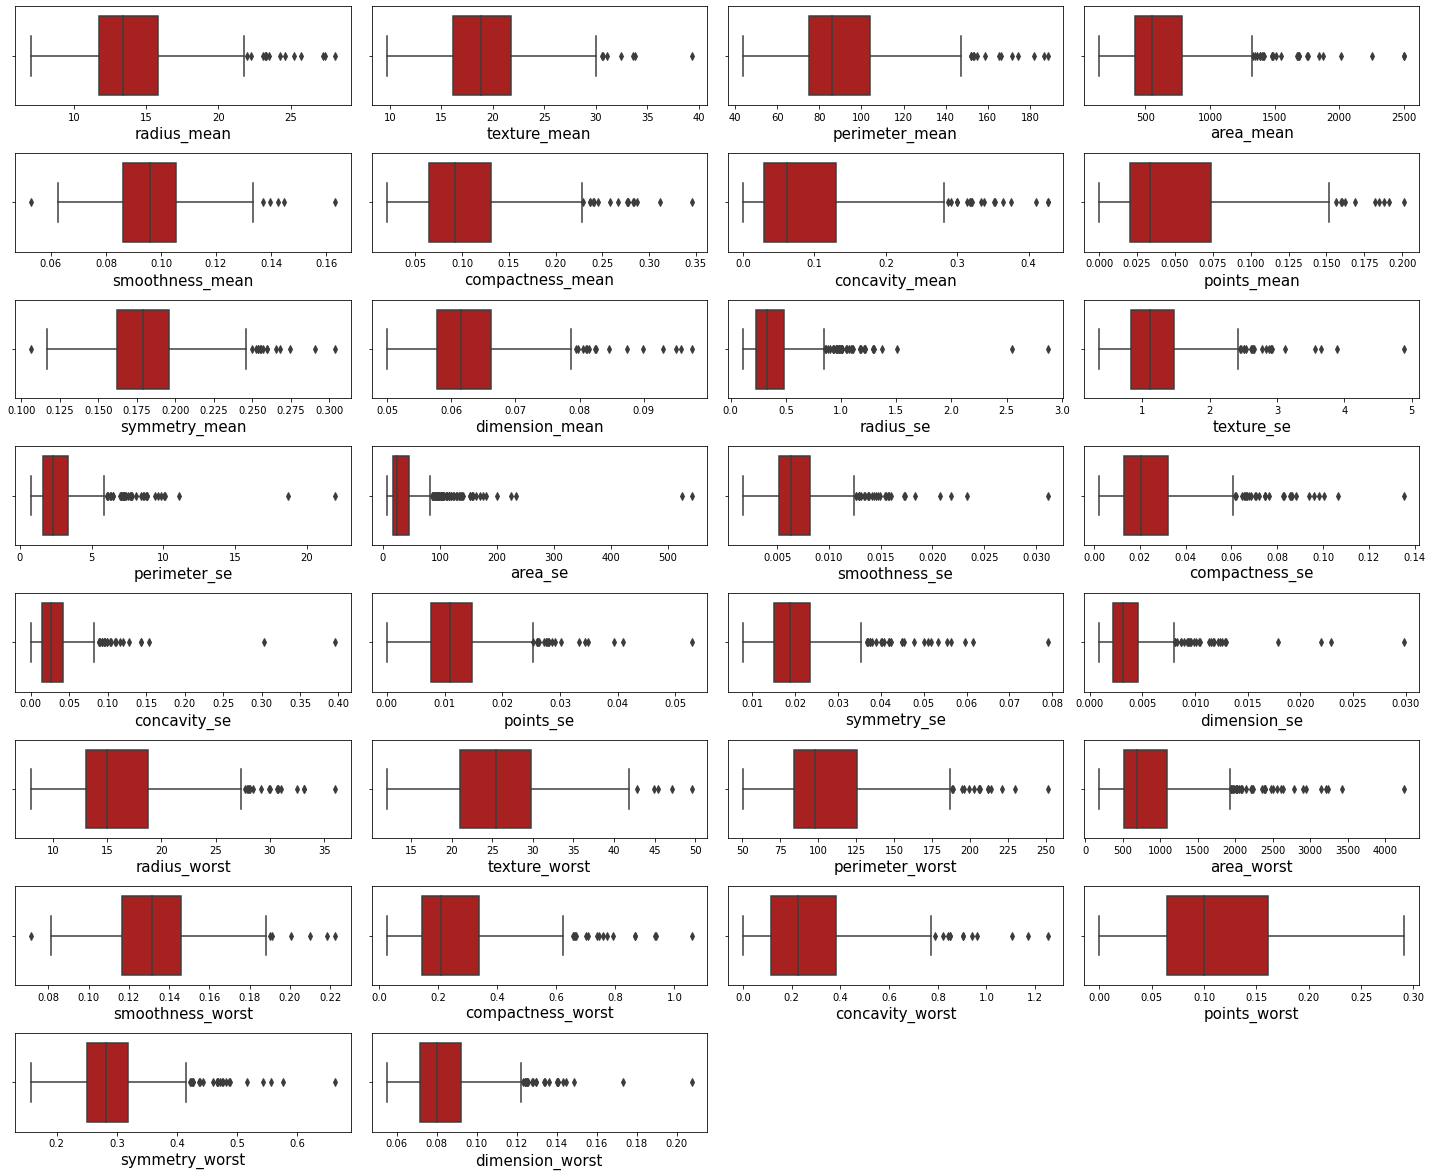

In [120]:
plt.figure(figsize = (20,20))
for i in enumerate(df.drop(['diagnosis'], axis = 1).columns):

  plt.subplot(10,4,i[0]+1)
  sns.boxplot(df[i[1]], color='#bd0b0b')
  plt.xlabel(i[1],fontsize = 15)
  plt.tight_layout()


### **Treating outliers using Capping (0.99) and Flooring (0.01)**


In [121]:
outliers_cols = []
for col in df.drop('diagnosis', axis = 1).columns:
  q25, q75 = np.percentile(df[col], 25), np.percentile(df[col], 75)
  iqr = q75 - q25
  outlier_th = iqr*1.5
  lower_th = q25 - outlier_th
  upper_th = q75 - outlier_th 
  if any(df[col].values < lower_th) or any(df[col].values > upper_th):
    outliers_cols.append(col)

print(outliers_cols)

['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'points_mean', 'symmetry_mean', 'dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'points_se', 'symmetry_se', 'dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'points_worst', 'symmetry_worst', 'dimension_worst']


In [122]:
for col in outliers_cols:
  percentiles = df[col].quantile([0.01, 0.99]).values
  df[col] = np.clip(df[col], percentiles[0], percentiles[1])



### **Checking the boxplots after taking care of Outliers**

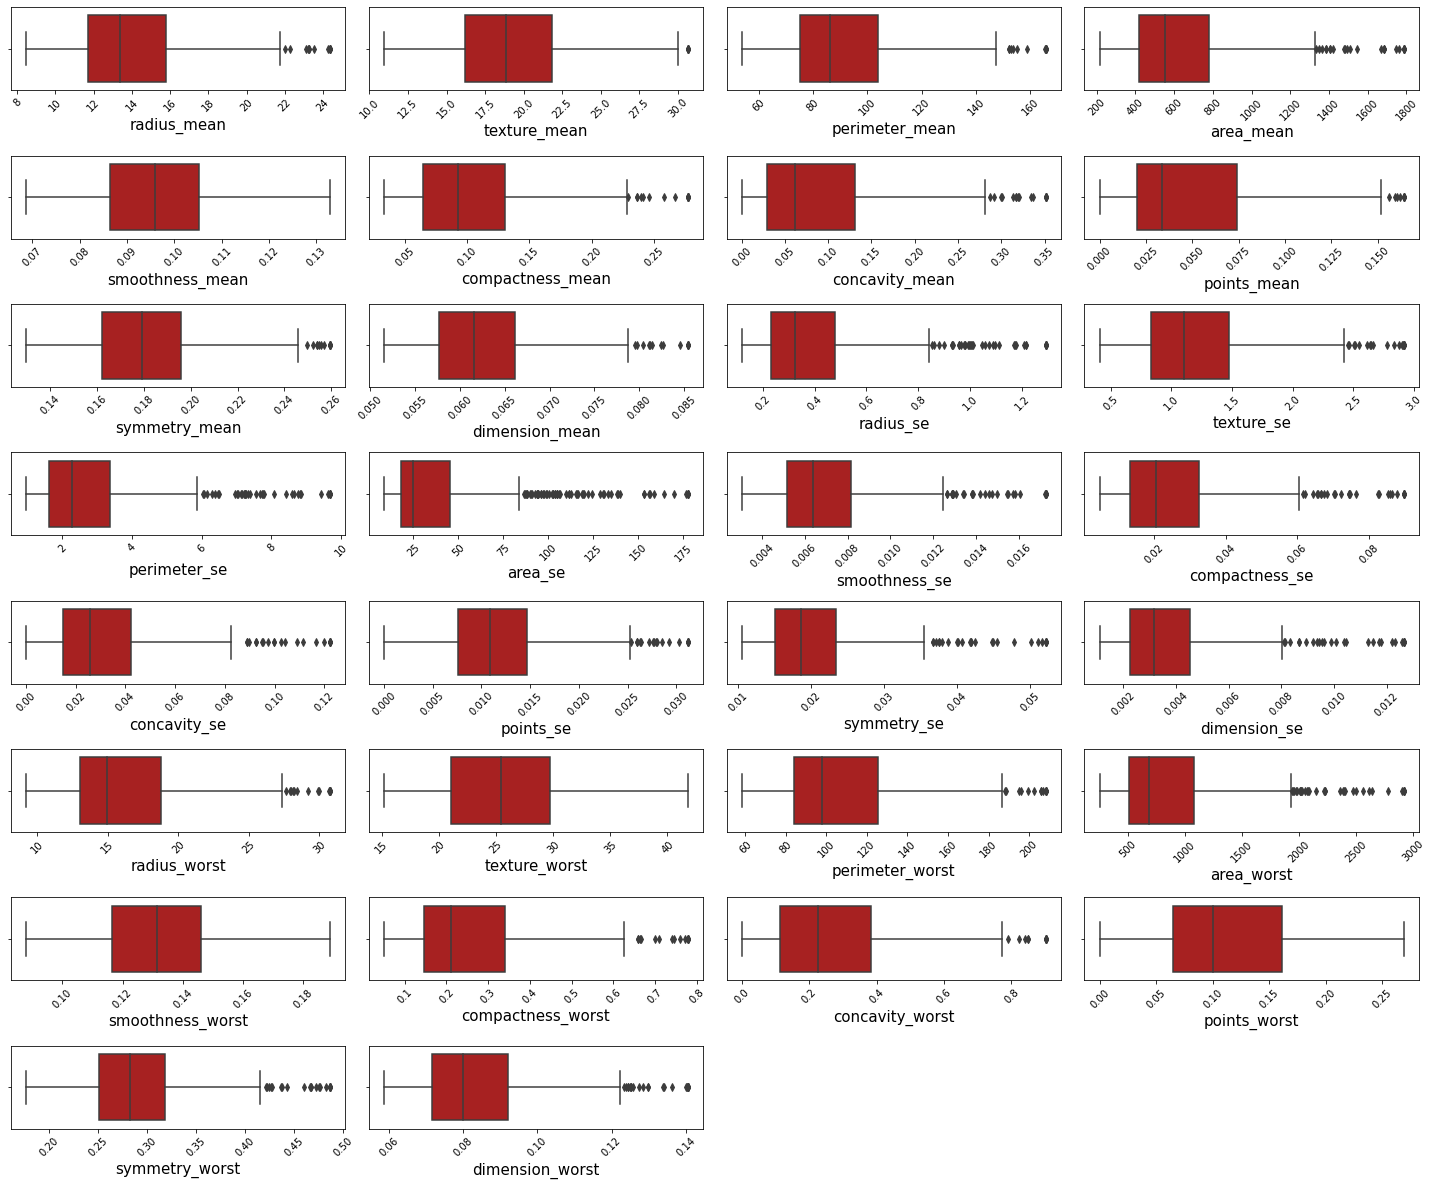

In [123]:
plt.figure(figsize = (20,20))
for i in enumerate(df.drop(['diagnosis'], axis = 1).columns):

  plt.subplot(10,4,i[0]+1)
  sns.boxplot(df[i[1]], color='#bd0b0b')
  plt.xlabel(i[1],fontsize = 15)
  plt.tight_layout()
  plt.xticks(rotation = 45)


### **Check the distribution**

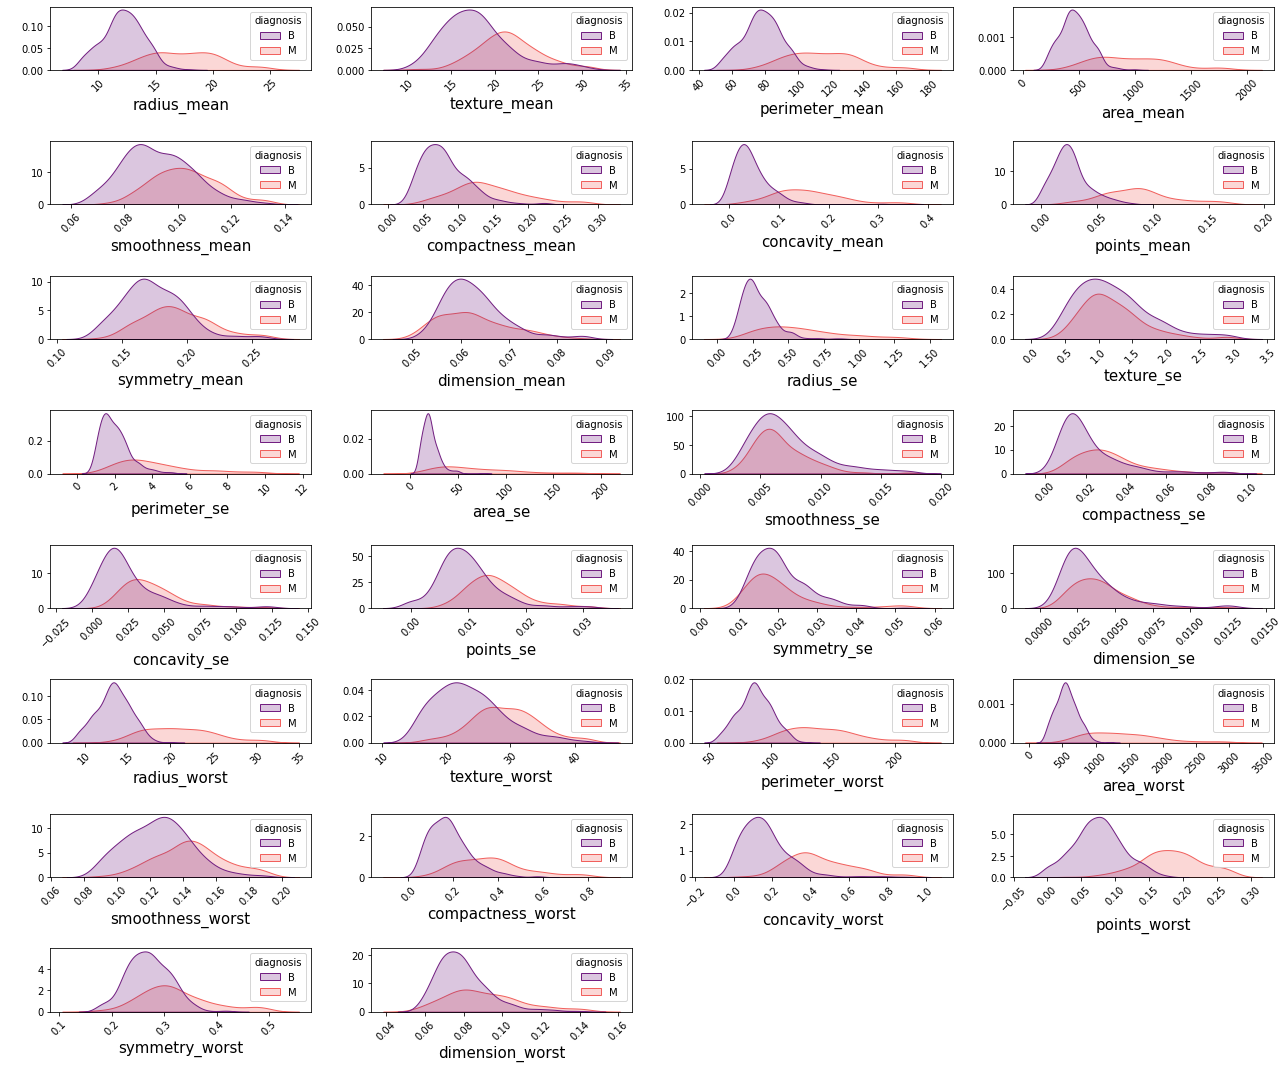

In [124]:
plt.figure(figsize = (18,18))
for i in enumerate(df.drop(['diagnosis'], axis = 1).columns):
  plt.subplot(10,4,i[0]+1)
  sns.kdeplot(data = df, x = i[1], hue = 'diagnosis', fill = 'magma', palette = 'magma' )
  plt.xlabel(i[1],fontsize = 15)
  plt.ylabel(" ")
  plt.xticks(rotation = 45)  
  plt.tight_layout()

In [125]:
df.diagnosis.value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

## **Observations:** 

---
- Variables like: radius_mean, texture_mean, perimeter_mean, points_worst etc columns clearly show that when value/units are small then the mass is benign (B) else malignant (M)
- Varibles like: smoothness_mean, texture_se, smoothness_se, symmetry_se, dimension_worst etc have B and M overlapped which means they are difficult to interpret visually w.r.t target variable (diagnosis)
- Data is unbalanced hence we can oversample or undersample the data.

## **6. Correlation using heatmap of Variables**

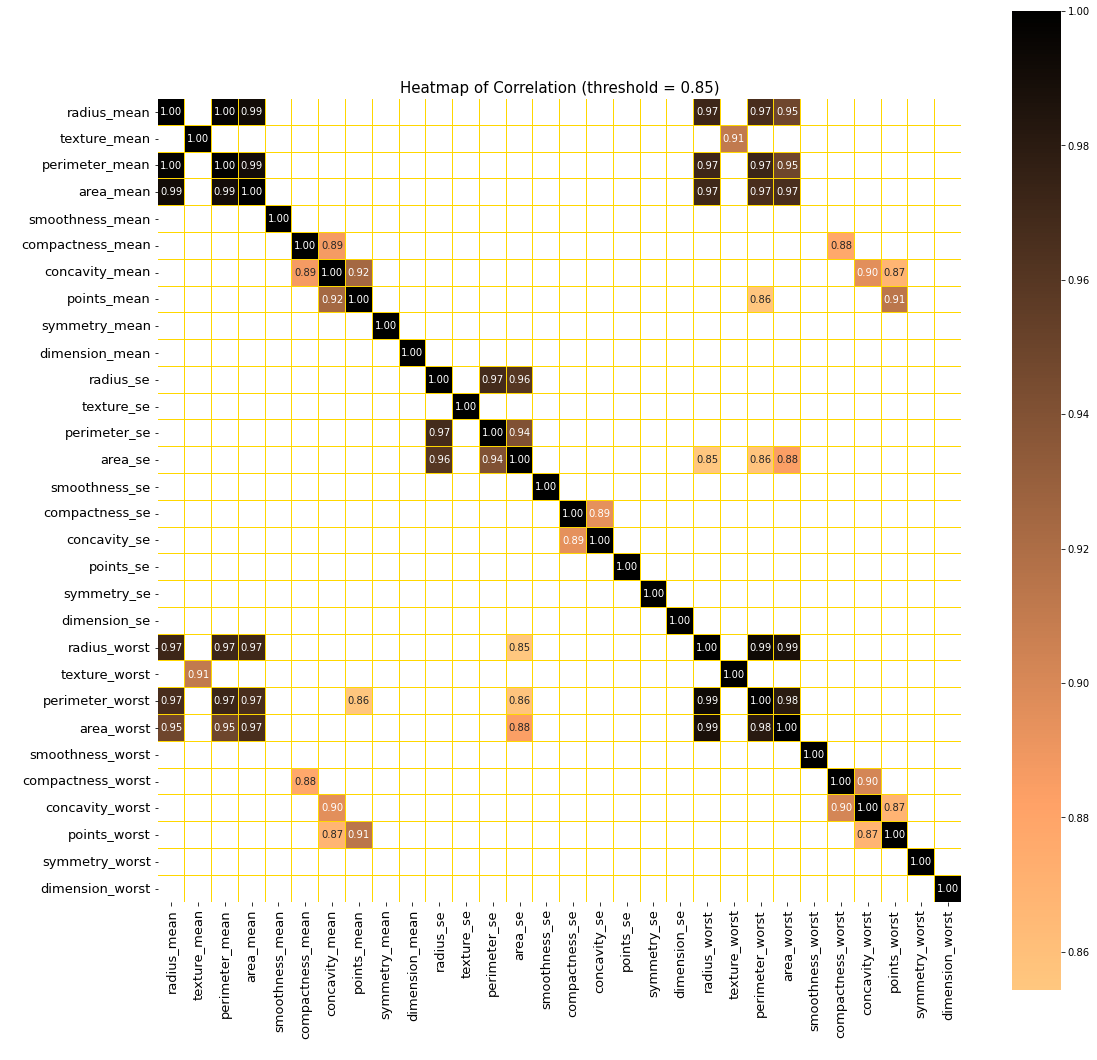

In [126]:
plt.figure(figsize=(18,18))
ax = sns.heatmap(df.corr(), annot = True, fmt='.2f', mask = df.corr() < .85, square = True, lw=0.01,linecolor='gold' , cmap = 'copper_r',)
plt.title("Heatmap of Correlation (threshold = 0.85)",fontsize = 15)
plt.xlabel(" ")
plt.ylabel(" ")
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.show();



## **7. Encoding target variable i.e.diagnosis to numeric.** 

---



- **Since we know B: Benign and M: Malignant** 
  - Let's use 1 for B: Benign and 0 for M: Malignant 

In [127]:
df.diagnosis = df.diagnosis.apply(lambda x: 1 if x == 'B' else 0) 
print(df.diagnosis.value_counts())

1    357
0    212
Name: diagnosis, dtype: int64


In [128]:
df.corrwith(df['diagnosis']).sort_values().to_frame().rename({0: 'Corr_with_diagnosis'}, axis = 1).style.background_gradient('copper')

,Corr_with_diagnosis
points_worst,-0.794885
perimeter_worst,-0.789946
points_mean,-0.784487
radius_worst,-0.782806
perimeter_mean,-0.750788
area_worst,-0.750746
radius_mean,-0.738236
area_mean,-0.728600
concavity_mean,-0.706309
concavity_worst,-0.675012


## **Observations:**
- Even with threshold of 0.85 we can see that independent variables are correlated with each other. Hence **``Multicolinearity exists``.**

# **8. Selecting Features by dropping multi-collinear variables. threshold = 0.85**

In [129]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

multi_collinear_cols = correlation(df.drop('diagnosis', axis = 1), 0.85)

In [130]:
list(multi_collinear_cols)

['radius_worst',
 'area_se',
 'perimeter_mean',
 'compactness_worst',
 'perimeter_worst',
 'area_mean',
 'points_worst',
 'texture_worst',
 'points_mean',
 'perimeter_se',
 'concavity_worst',
 'concavity_se',
 'area_worst',
 'concavity_mean']

### **Dropping multi-collinear features**

In [131]:
new_df = df.drop(list(multi_collinear_cols), axis = 1)

# **9. Training 3 Models** 
- **RandomForestClassifier, LogisticRegression and SGDClassifier** and checking:
  - Is model Generalized?
  - If Generalized model: Model can be deployed?
  - Selected Top-2 Features from the model which could be used for deployment.

In [132]:
"""Setting up data for train-test split"""
X = new_df.drop(['diagnosis'], axis =1)
Y = new_df.diagnosis 

"""Performing Train-Test Split"""
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, stratify = Y, random_state=10 )

"""Standardizing the data"""
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

RandomForestClassifier
Number of Features used including Target variable: 17
Variables selected using Correlation matrix result. Multicollinearity Threshold used to eliminate variable 0.85.


RandomForestClassifier(n_estimators=10, random_state=7) is not a Genralized Model. 
- We cannot consider this model for deployment.     
- Either roc_auc_score_test < roc_auc_score_train OR roc_auc_score_test < CL 

roc_auc_score_train: 1.0
roc_auc_score_test: 0.9438522196261683
CL decided: 0.85
No Further Action for model: RandomForestClassifier(n_estimators=10, random_state=7)


SGDClassifier
Number of Features used including Target variable: 17
Variables selected using Correlation matrix result. Multicollinearity Threshold used to eliminate variable 0.85.


SGDClassifier(loss='log', random_state=7) is generalized because roc_auc_score_test > roc_auc_score_train AND roc_auc_score_test > CL
roc_auc_score_train: 0.9455945945945945
roc_auc_score_test: 0.9734959112149533
CL decided: 0.85


Since Mod

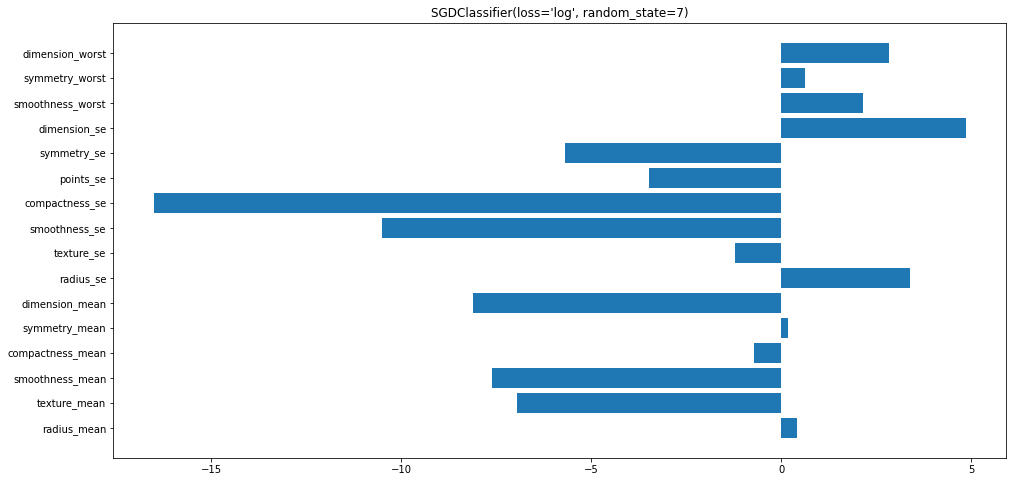

dimension_se         4.849558
smoothness_se        3.399753
compactness_mean     2.839625
dimension_mean       2.143208
compactness_se       0.627602
texture_se           0.413889
symmetry_mean        0.166012
symmetry_se         -0.722922
smoothness_mean     -1.206879
points_se           -3.474168
dimension_worst     -5.680995
texture_mean        -6.943012
symmetry_worst      -7.613056
smoothness_worst    -8.116944
radius_se          -10.507914
radius_mean        -16.512149
dtype: float64



LogisticRegression
Number of Features used including Target variable: 17
Variables selected using Correlation matrix result. Multicollinearity Threshold used to eliminate variable 0.85.


LogisticRegression(random_state=7) is generalized because roc_auc_score_test > roc_auc_score_train AND roc_auc_score_test > CL
roc_auc_score_train: 0.9615945945945946
roc_auc_score_test: 0.9734959112149533
CL decided: 0.85


Since Model is generalized. Let's check Confusion Matrix and Classification Report


Classification report of Train Data: 
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       148
           1       0.96      0.98      0.97       250

    accuracy                           0.97       398
   macro avg       0.97      0.96      0.96       398
weighted avg       0.97      0.97      0.97       398


Classification report of Test Data: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.9

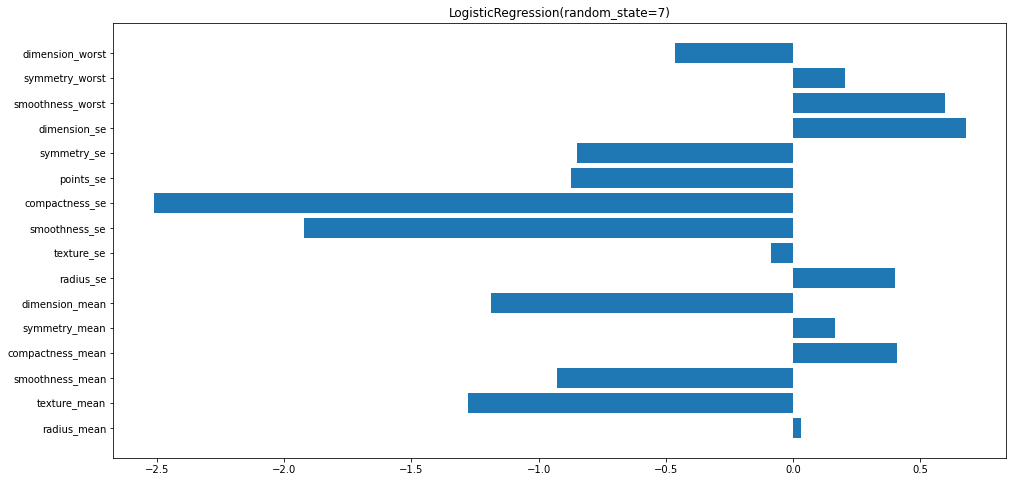

dimension_se        0.677693
dimension_mean      0.594998
symmetry_se         0.407953
smoothness_se       0.400529
compactness_se      0.203997
symmetry_mean       0.163280
texture_se          0.029282
smoothness_mean    -0.085559
compactness_mean   -0.463410
dimension_worst    -0.850302
points_se          -0.874371
symmetry_worst     -0.929227
smoothness_worst   -1.185684
texture_mean       -1.276695
radius_se          -1.920457
radius_mean        -2.512198
dtype: float64

In [133]:
models = ['RandomForestClassifier','SGDClassifier','LogisticRegression']
CL = 0.85
final_models = []

for model in models:
  print(model)
  print(f"Number of Features used including Target variable: {len(X_train.columns)+1}")
  print(f"Variables selected using Correlation matrix result. Multicollinearity Threshold used to eliminate variable 0.85.")
  if model == 'RandomForestClassifier':
    model = RandomForestClassifier(n_estimators=10, random_state = 7)
    model.fit(X_train_scaled, y_train)
    final_models.append(model)
    importance = model.feature_importances_
  if model == 'SGDClassifier':
    model = SGDClassifier(loss = 'log',random_state = 7)
    model.fit(X_train_scaled, y_train)
    final_models.append(model)
    importance = model.coef_[0]
  if model == 'LogisticRegression':
    model = LogisticRegression(random_state = 7)
    model.fit(X_train_scaled, y_train)
    final_models.append(model)
    importance = model.coef_[0]
  

  train_preds = model.predict_proba(X_train_scaled)[:,1]
  test_preds = model.predict_proba(X_test_scaled)[:,1]

  print('\n')
  if roc_auc_score(y_train, train_preds.round()) > roc_auc_score(y_test, test_preds.round()) or roc_auc_score(y_test, test_preds.round()) < CL:
    print(f"{model} is not a Genralized Model. \n- We cannot consider this model for deployment. \
    \n- Either roc_auc_score_test < roc_auc_score_train OR roc_auc_score_test < CL \n")
    print(f"roc_auc_score_train: {roc_auc_score(y_train, train_preds.round())}")
    print(f'roc_auc_score_test: {roc_auc_score(y_test, test_preds.round())}')
    print(f"CL decided: {CL}")
    print(f"No Further Action for model: {model}")
  if roc_auc_score(y_train, train_preds.round()) < roc_auc_score(y_test, test_preds.round()) and roc_auc_score(y_test, test_preds.round()) > CL: 
    print(f"{model} is generalized because roc_auc_score_test > roc_auc_score_train AND roc_auc_score_test > CL")
    print(f'roc_auc_score_train: {roc_auc_score(y_train, train_preds.round())}')
    print(f'roc_auc_score_test: {roc_auc_score(y_test, test_preds.round())}')
    print(f"CL decided: {CL}")
    print('\n')
    print("Since Model is generalized. Let's check Confusion Matrix and Classification Report")
    print('\n')
    print(f"Classification report of Train Data: \n{classification_report(y_train, train_preds.round())}")
    print()
    print(f"Classification report of Test Data: \n{classification_report(y_test, test_preds.round())}")
    print('\n')
    print(f"Confusion Matrix of Train Data: \n{confusion_matrix(y_train, train_preds.round())}")
    print('\n')
    print(f"Confusion Matrix of Test Data: \n{confusion_matrix(y_test, test_preds.round())}")
    print('\n')

    # plot feature importance
    #reference: https://stackoverflow.com/questions/44511636/plot-feature-importance-with-feature-names
    feat_importances = pd.Series(importance, index=X_train.columns)

    plt.barh(feat_importances.index, feat_importances.sort_index(ascending = False).values )
    plt.title(model)
    plt.show()

    display(feat_importances.sort_values(ascending = False))
  print('\n')
  print('='*100)



In [134]:
model_sgd, model_log_reg= final_models[1], final_models[2]
model_sgd, model_log_reg

(SGDClassifier(loss='log', random_state=7), LogisticRegression(random_state=7))

# **Observations after Checking Generalization of 3 models:**

---


- Given SL = 0.15, therefore CL = 1-SL = 0.85.
- We have SGDClassifier and Logistic Regression selected as Generalized models.
- Features used are from Correlation matrix, where threshold of 0.85 was selected and one of two independent features with correlation more than 0.85 were removed. 
- Since our data is unbalanced accuracy was not used and roc_auc_score was used to determine Genralization of individual models. 
- Moreover F-1 score of SGDClassifier and Logistic Regression is better with test_data when compared to train_data.

### **MODEL-1- best model based on Confusion Matrix and Numerical Metrics:  SGDClassifier**:
-  F-1 Score and metrics from confusion matrix has improved better from train_set to test_set when compared with ``Logistic Regression``

### **MODEL-2- Model2: Get the best model based on Viz Metrics: Logistic Regression**:
-  roc_auc_score has less difference in train and test data when compared to ``SGDClassifier``

### **Now we use both models to get top-2 features and compare thier results.**


## **Feature importance interpretability:**

---


- SGDCLassifier gave **dimension_mean and smoothness_se** as top-2 variables.
- Logistic Regression gave **dimension_se and dimension_mean** as top-2 variables.
  

# **10. Let's use some methods from ``sklearn.feature_selection``**
- **Using ``RFE`` and ``SelectFromModel`` to select top-2 features.**
- Since our data is small we can use Logistic Regression which uses Gradient Descent. 

In [137]:
from sklearn.feature_selection import RFE, SelectFromModel

In [138]:
"""Setting up data for train-test split"""
X = df.drop(['diagnosis'], axis =1)
Y = df.diagnosis 

"""Performing Train-Test Split"""
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, stratify = Y, random_state=10 )

"""Standardizing the data"""
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [140]:
"""RFE: Recursive Feature Elimination."""
# referene: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE
estimators  = [model_log_reg, model_sgd]
for estimator in estimators:
  print(f"present Model: {estimator}")
  selector = RFE(estimator, n_features_to_select=2, step=1)
  selector = selector.fit(X_train_scaled, y_train)
  print(f"Top-2 Features as per order of X_train.columns shown as 'True': \n{selector.support_}\n")

  print(f"Ranked-index of Features. Top two features are marked as 1, order is same as X_train.columns: \n{selector.ranking_}\n")

  print(f"X_train.columns: \n{list(X_train_scaled.columns)}\n")

  print(f"Top-2 features after RFE: \n{selector.get_feature_names_out()}\n")
  print("="*100)



present Model: LogisticRegression(random_state=7)
Top-2 Features as per order of X_train.columns shown as 'True': 
[False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False  True False False]

Ranked-index of Features. Top two features are marked as 1, order is same as X_train.columns: 
[19 15 17 13 27 16 10  5 23 29  7 11 14  2 28  9 24 22 25 20  3  4  6  1
 12 26  8  1 18 21]

X_train.columns: 
['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'points_mean', 'symmetry_mean', 'dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'points_se', 'symmetry_se', 'dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'points_worst', 'symmetry_worst', 'dimension_wor

In [142]:
"""Select From Model: Meta-transformer for selecting features based on importance weights."""
# referene: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel
estimators  = [model_log_reg,model_sgd]
for estimator in estimators:
  print(f"Present Model: {estimator}")
  selector1 = SelectFromModel(estimator=estimator, max_features=2).fit(X_train_scaled, y_train)

  print(f"Coefficients used: \n{selector1.estimator_.coef_}\n")

  print(f"Thresholds used \n{selector1.threshold_}\n")

  print(f"X_train.columns: \n{list(X_train.columns)}\n")

  print(f"Top features to be selected shown in True and False  \n{selector1.get_support()}\n")

  print(f"Top-2 features after Select_From_Model: \n{selector1.get_feature_names_out()}\n")
  print("="*100)



Present Model: LogisticRegression(random_state=7)
Coefficients used: 
[[-0.25929329 -0.48464633 -0.30351255 -0.41725459 -0.07765283  0.49297068
  -1.02030579 -0.90654351  0.25175312  0.03672161 -1.01741683  0.41726752
  -0.53007478 -1.01090929  0.06658748  0.88823693 -0.28463338 -0.30577085
   0.16994815  0.49297504 -0.84584761 -1.26679937 -0.69932948 -0.86217297
  -0.61137143  0.13230311 -0.67548887 -0.68948374 -0.60168091 -0.41586338]]

Thresholds used 
0.5411605142005099

X_train.columns: 
['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'points_mean', 'symmetry_mean', 'dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'points_se', 'symmetry_se', 'dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'points_worst', 'symmetry_worst', 'dimension_worst']

Top

## **Observations:** 
- From Logistic Regression we got: 
  - Removing Multi-collinear cols: **dimension_se and dimension_mean** 
  - RFE: **'area_worst' and 'points_worst'**
  - Select_From_Model: **'concavity_mean' and 'texture_worst'**
- From SGDClassifier we got: 
  - Removing Multi-collinear cols: **dimension_mean and smoothness_se**
  - RFE: **'points_mean' and 'area_se'**
  - Select_From_Model: **'area_se' and 'texture_worst'**
- Now let's use these combination and compare the results.


# **11. Train models using top-2 Variables combinations**
- Select the best 2 variables:
  - Check if model is still generalized
  - Can model be deployed? i.e. test_prediction_score > CL decided




### **Using Logistic Regression and combination of top-2 variables selected by different methods.**

In [156]:
dict_variables_log_reg = {'multi_col_method_var' :['dimension_se', 'dimension_mean'], 'RFE_var': ['area_worst' ,'points_worst'],
                          'select_from_model_var': [ 'concavity_mean', 'texture_worst']}
for key, val in dict_variables_log_reg.items():
  xtrain = X_train_scaled.copy()[val]
  ytrain = y_train.copy()

  xtest = X_test_scaled.copy()[val]
  ytest = y_test.copy()
  print(key,val)
  model_log_reg.fit(xtrain, ytrain)
  train_preds = model_log_reg.predict_proba(xtrain)[:,1]
  test_preds = model_log_reg.predict_proba(xtest)[:,1]
  print(f'roc_auc_score_train: {roc_auc_score(ytrain, train_preds.round())}')
  print(f'roc_auc_score_test: {roc_auc_score(ytest, test_preds.round())}')
  print(f"CL decided: {CL}")
  print('\n')

  print(f"Classification report of Train Data: \n{classification_report(ytrain, train_preds.round())}")
  print()
  print(f"Classification report of Test Data: \n{classification_report(ytest, test_preds.round())}")
  print('\n')
  print(f"Confusion Matrix of Train Data: \n{confusion_matrix(ytrain, train_preds.round())}")
  print('\n')
  print(f"Confusion Matrix of Test Data: \n{confusion_matrix(ytest, test_preds.round())}")
  print('='*100)

multi_col_method_var ['dimension_se', 'dimension_mean']
roc_auc_score_train: 0.49427027027027026
roc_auc_score_test: 0.5281834112149533
CL decided: 0.85


Classification report of Train Data: 
              precision    recall  f1-score   support

           0       0.32      0.04      0.07       148
           1       0.63      0.95      0.75       250

    accuracy                           0.61       398
   macro avg       0.47      0.49      0.41       398
weighted avg       0.51      0.61      0.50       398


Classification report of Test Data: 
              precision    recall  f1-score   support

           0       0.60      0.09      0.16        64
           1       0.64      0.96      0.77       107

    accuracy                           0.64       171
   macro avg       0.62      0.53      0.47       171
weighted avg       0.62      0.64      0.54       171



Confusion Matrix of Train Data: 
[[  6 142]
 [ 13 237]]


Confusion Matrix of Test Data: 
[[  6  58]
 [  4 103]]


### **Using SGDClassifier and combination of top-2 variables selected by different methods.**

In [145]:
dict_variables_sgd = {'multi_col_method_var' :['dimension_mean' , 'smoothness_se'], 'RFE_var': ['points_mean' , 'area_se'],
                          'select_from_model_var': ['area_se' , 'texture_worst']}

for key, val in dict_variables_sgd.items():
  xtrain = X_train_scaled.copy()[val]
  ytrain = y_train.copy()

  xtest = X_test_scaled.copy()[val]
  ytest = y_test.copy()
  print(key,val)
  model_sgd.fit(xtrain, ytrain)
  train_preds = model_sgd.predict_proba(xtrain)[:,1]
  test_preds = model_sgd.predict_proba(xtest)[:,1]
  print(f'roc_auc_score_train: {roc_auc_score(ytrain, train_preds.round())}')
  print(f'roc_auc_score_test: {roc_auc_score(ytest, test_preds.round())}')
  print(f"CL decided: {CL}")
  print('\n')

  print(f"Classification report of Train Data: \n{classification_report(ytrain, train_preds.round())}")
  print()
  print(f"Classification report of Test Data: \n{classification_report(ytest, test_preds.round())}")
  print('\n')
  print(f"Confusion Matrix of Train Data: \n{confusion_matrix(ytrain, train_preds.round())}")
  print('\n')
  print(f"Confusion Matrix of Test Data: \n{confusion_matrix(ytest, test_preds.round())}")
  print('='*100)

multi_col_method_var ['dimension_mean', 'smoothness_se']
roc_auc_score_train: 0.5193243243243244
roc_auc_score_test: 0.4927716121495327
CL decided: 0.85


Classification report of Train Data: 
              precision    recall  f1-score   support

           0       0.40      0.40      0.40       148
           1       0.64      0.64      0.64       250

    accuracy                           0.55       398
   macro avg       0.52      0.52      0.52       398
weighted avg       0.55      0.55      0.55       398


Classification report of Test Data: 
              precision    recall  f1-score   support

           0       0.37      0.36      0.36        64
           1       0.62      0.63      0.62       107

    accuracy                           0.53       171
   macro avg       0.49      0.49      0.49       171
weighted avg       0.52      0.53      0.53       171



Confusion Matrix of Train Data: 
[[ 59  89]
 [ 90 160]]


Confusion Matrix of Test Data: 
[[23 41]
 [40 67]]
RFE_

## **Conclusion:**
- Two model Selected: **Logistic Regression and SGDClassifier**
- From Logistic Regression we got: 
  - Removing Multi-collinear cols: **Model is not Generalized model** 
  - RFE: **Model is generalized and gave 0.98 accuracy and 0.98 as roc_auc_score on test-data**
  - Select_From_Model: **Model is generalized and gave 0.85 accuracy and 0.89 as roc_auc_score.**
- From SGDClassifier we got: 
  - Removing Multi-collinear cols: **Model is not Generalized model**
  - RFE: **Model is generalized and gave 0.98 accuracy and 0.98 as roc_auc_score on test-data**
  - Select_From_Model: **Model is generalized and gave 0.90 accuracy and 0.89 as roc_auc_score on test-data**

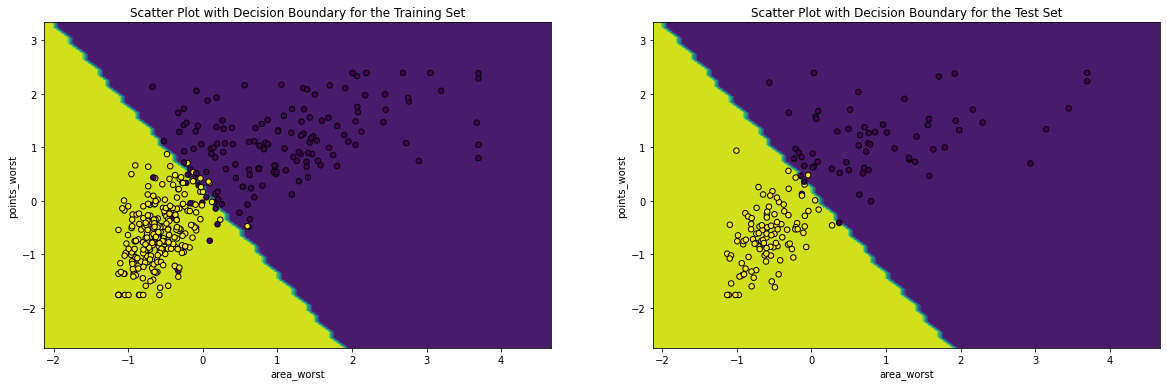

In [196]:
# Reference: https://favtutor.com/blogs/decision-boundary-logistic-regression
RFE_var = ['area_worst' ,'points_worst']

xtrain = X_train_scaled.copy()[RFE_var].values
ytrain = y_train.copy().values

xtest = X_test_scaled.copy()[RFE_var].values
ytest = y_test.copy().values
model_log_reg.fit(xtrain, ytrain)
train_preds = model_log_reg.predict_proba(xtrain)[:,1]
test_preds = model_log_reg.predict_proba(xtest)[:,1]


# plotting the decision boundary in the scatter plot of Training and Test Set with labels indicated by colors
x_min, x_max = xtrain[:, 0].min() - 1, xtrain[:, 0].max() + 1
y_min, y_max = xtrain[:, 1].min() - 1, xtrain[:, 1].max() + 1

xx_train, yy_train = np.meshgrid(np.arange(x_min, x_max, 0.1),
                                 np.arange(y_min, y_max, 0.1))

Z_train = model_log_reg.predict(np.c_[xx_train.ravel(), yy_train.ravel()])
Z_train = Z_train.reshape(xx_train.shape)


x_min, x_max = xtest[:, 0].min() - 1, xtest[:, 0].max() + 1
y_min, y_max = xtest[:, 1].min() - 1, xtest[:, 1].max() + 1

xx_test, yy_test = np.meshgrid(np.arange(x_min, x_max, 0.1),
                               np.arange(y_min, y_max, 0.1))

Z_test = model_log_reg.predict(np.c_[xx_test.ravel(), yy_test.ravel()])
Z_test = Z_test.reshape(xx_test.shape)

plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.contourf(xx_train, yy_train, Z_train)
plt.scatter(xtrain[:, 0], xtrain[:, 1], c = y_train, s = 30, edgecolor = 'k')
plt.xlabel(f'{RFE_var[0]}')
plt.ylabel(f'{RFE_var[1]}')
plt.title('Scatter Plot with Decision Boundary for the Training Set')
plt.subplot(1, 2, 2)
plt.contourf(xx_test, yy_test, Z_test)
plt.scatter(xtest[:, 0], xtest[:, 1], c = y_test, s = 30, edgecolor = 'k')
plt.xlabel(f'{RFE_var[0]}')
plt.ylabel(f'{RFE_var[1]}')
plt.title('Scatter Plot with Decision Boundary for the Test Set')
plt.show()

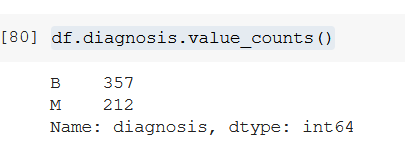


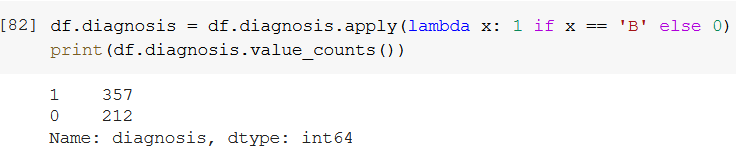

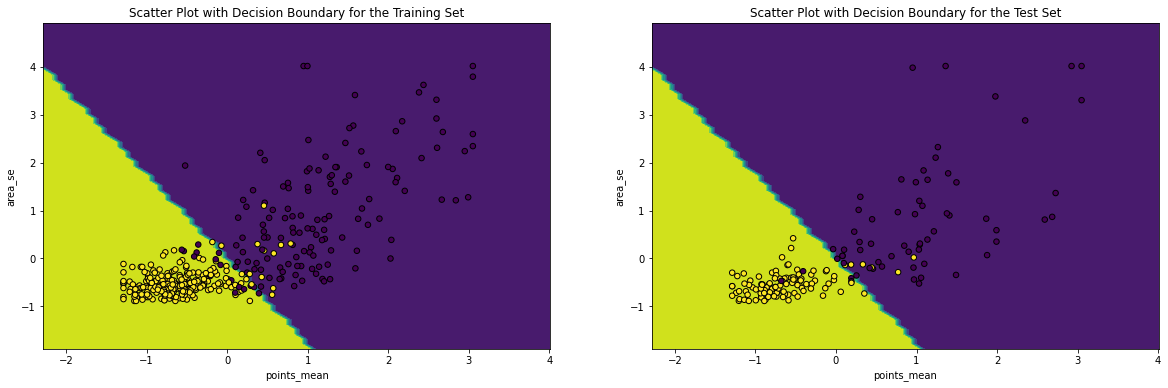

In [197]:
# Reference: https://favtutor.com/blogs/decision-boundary-logistic-regression
RFE_var = ['points_mean', 'area_se']

xtrain = X_train_scaled.copy()[RFE_var].values
ytrain = y_train.copy().values

xtest = X_test_scaled.copy()[RFE_var].values
ytest = y_test.copy().values
model_sgd.fit(xtrain, ytrain)
train_preds = model_sgd.predict_proba(xtrain)[:,1]
test_preds = model_sgd.predict_proba(xtest)[:,1]


# plotting the decision boundary in the scatter plot of Training and Test Set with labels indicated by colors
x_min, x_max = xtrain[:, 0].min() - 1, xtrain[:, 0].max() + 1
y_min, y_max = xtrain[:, 1].min() - 1, xtrain[:, 1].max() + 1

xx_train, yy_train = np.meshgrid(np.arange(x_min, x_max, 0.1),
                                 np.arange(y_min, y_max, 0.1))

Z_train = model_sgd.predict(np.c_[xx_train.ravel(), yy_train.ravel()])
Z_train = Z_train.reshape(xx_train.shape)


x_min, x_max = xtest[:, 0].min() - 1, xtest[:, 0].max() + 1
y_min, y_max = xtest[:, 1].min() - 1, xtest[:, 1].max() + 1

xx_test, yy_test = np.meshgrid(np.arange(x_min, x_max, 0.1),
                               np.arange(y_min, y_max, 0.1))

Z_test = model_sgd.predict(np.c_[xx_test.ravel(), yy_test.ravel()])
Z_test = Z_test.reshape(xx_test.shape)

plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.contourf(xx_train, yy_train, Z_train)
plt.scatter(xtrain[:, 0], xtrain[:, 1], c = y_train, s = 30, edgecolor = 'k')
plt.xlabel(f'{RFE_var[0]}')
plt.ylabel(f'{RFE_var[1]}')
plt.title('Scatter Plot with Decision Boundary for the Training Set')
plt.subplot(1, 2, 2)
plt.contourf(xx_test, yy_test, Z_test)
plt.scatter(xtest[:, 0], xtest[:, 1], c = y_test, s = 30, edgecolor = 'k')
plt.xlabel(f'{RFE_var[0]}')
plt.ylabel(f'{RFE_var[1]}')
plt.title('Scatter Plot with Decision Boundary for the Test Set')
plt.show()

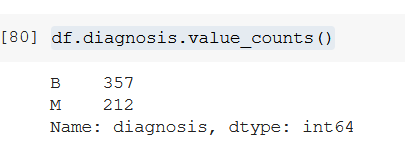


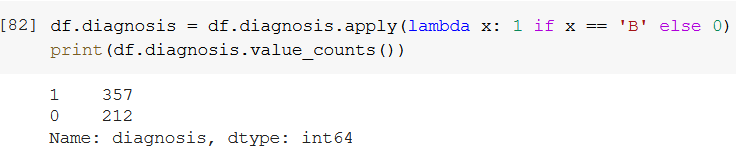

# **13. Deployment Code:**
- Let's randomly take a row from scaled_data and try to predict the result.
- Next we can randomly give some valid values to the model and observe its prediction.

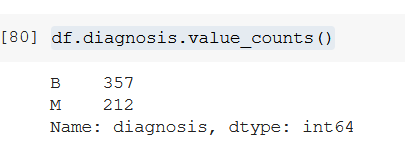


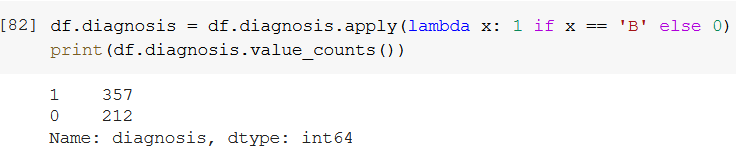

## **1 = B**
## **0 = M**

In [146]:
final_models = [model_sgd, model_log_reg]
final_models

[SGDClassifier(loss='log', random_state=7), LogisticRegression(random_state=7)]

In [147]:
# some_0_or_M_index: 5,14,15,16,20
# some_1_or_B_index: 0,1,2,3,4

In [148]:
index_ =4
query_data = X_train_scaled.iloc[index_][['radius_mean', 'radius_se']].values.reshape(1,-1)
print(f"Original Decision: {y_train.iloc[index_]}")

Original Decision: 1


In [149]:
query_data

array([[-0.14214555, -0.7193692 ]])

In [152]:
for final_model in final_models:
  print(f"Present Model: {final_model}")
  decision = "1 or B"
  if final_model.predict_proba(query_data)[:,1][0] < CL:
    decision = "0 or M"
    

  print(f"Original Decision: {y_train.iloc[index_]}, \n\
  Prediction Probability: {final_model.predict_proba(query_data)[:,1][0]}, \n\
  Decision of model as per CL: {decision}\n")
  print("="*100)

Present Model: SGDClassifier(loss='log', random_state=7)
Original Decision: 1, 
  Prediction Probability: 0.8637914265902683, 
  Decision of model as per CL: 1 or B

Present Model: LogisticRegression(random_state=7)
Original Decision: 1, 
  Prediction Probability: 0.8736823288021991, 
  Decision of model as per CL: 1 or B



### **Prediction on Random data**


In [153]:
radius_mean = float(input("Enter a float for radius_mean (could be negative): "))
radius_se = float(input("Enter a float for radius_se (could be negative): "))


Enter a float for radius_mean (could be negative): 0.98
Enter a float for radius_se (could be negative): -.98


In [154]:
query_data = np.array([radius_mean, radius_se]).reshape(1,-1)
query_data

array([[ 0.98, -0.98]])

In [155]:
for final_model in final_models:
  decision = "1 or B"
  if final_model.predict_proba(query_data)[:,1][0] < CL:
    decision = "0 or M"
    

  print(f"Prediction Probability: {final_model.predict_proba(query_data)[:,1][0]}, \n\
  Decision of model as per CL: {decision}\n")
  print("="*100)

Prediction Probability: 0.04274466319137476, 
  Decision of model as per CL: 0 or M

Prediction Probability: 0.3353220135294454, 
  Decision of model as per CL: 0 or M

